In [1]:
#Standard Header used on the projects

#first the major packages used for math and graphing
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler

from joblib import Parallel, delayed

#Custome graph format style sheet
plt.style.use('Prospectus.mplstyle')

#If being run by a seperate file, use the seperate file's graph format and saving paramaeters
#otherwise set what is needed
if not 'Saving' in locals():
    Saving = True
if not 'Titles' in locals():
    Titles = True
if not 'Ledgends' in locals():
    Ledgends = True
if not 'FFormat' in locals():
    FFormat = '.eps'
if not 'location' in locals():
    #save location.  First one is for running on home PC, second for running on the work laptop.  May need to make a global change
    location = 'E:\\Documents\\Dan\\Code\\FigsAndPlots\\FigsAndPlotsDocument\\Figures\\'
    #location = 'C:\\Users\\dhendrickson\\Documents\\github\\FigsAndPlots\\FigsAndPlotsDocument\\Figures\\'



In [2]:
# Task Specific includes:

#import scipy.special as sp
import math
import matplotlib.animation as animation
import time
from numpy import inf
# Choose which EFIT_Class to use:
#import EFIT_Class as EFIT
#import EFIT_Class_StressLargerVelocity as EFIT
#import EFIT_Class_OrignalEqualGrid as EFIT
#import EFIT_Class_Parallel_EqualGrid as EFIT
#import EFIT_Class_VelocityLargerStress as EFIT
#import EFIT_Class_OrignalEqualGrid_axisFlipper as EFIT
import EFIT_Class_EqualGrid1eq as EFIT
#import visvis as vv

In [3]:
# set Constants:
PoissonRatio = 0.3
YoungModulus = 20 * (10**9)
mu = 80 * (10**9)         #First Lame Parameter
lmbda = 2 * mu * PoissonRatio / (1 - 2 * PoissonRatio)     #second Lame Parameter
rho = 7800       #density kg/m^3

#Calculate speed of longitudinal and transverse waves
cl = np.sqrt((lmbda + 2* mu)/rho)
ct = np.sqrt(mu/rho)

#Choose ferquency to be used for excitment
frequency = 40000

#calculate wave length
omegal = cl / frequency
omegat = ct / frequency

#check max step size
dtmax = 1/ (max(cl,ct) * np.sqrt(3/(min(omegal,omegat)/10)))


# about 1foot (0.3m) of just the web of 175lbs rail 
# BeamLength = 0.3
# BeamHeight = 0.0762
# BeamWidth = 0.0381
BeamLength = 0.04
BeamHeight = 0.04
BeamWidth = 0.04

#Run for 6 Cycles:
runtime = 8.0 / frequency 

#Set time step and grid step to be 10 steps per frequency and ten steps per wavelength respectively
ts = (1 / frequency) / 20  #  5e-08  #time step
gs = min(omegal, omegat) / 50    #grid step

Tsteps = int(math.ceil(runtime / ts)) + 1       #total Time STeps

gl = int(math.ceil(BeamLength / gs))         #number of grid points
gh = int(math.ceil(BeamHeight / gs)) 
gw = int(math.ceil(BeamWidth / gs)) 

print(dtmax,ts)

8.622367091851726e-06 1.25e-06


In [4]:
def makeAnimation(CenterZResults, title='Z'):
    y = np.linspace(0, BeamHeight, np.shape(CenterZResults[0][0])[1])
    x = np.linspace(0, BeamLength, np.shape(CenterZResults[0][0])[0])
    x,y = np.meshgrid(x,y)

    fig = plt.figure(figsize=(6.0,BeamHeight/BeamLength*6.0), dpi=100)
    ax = plt.axes(xlim=(0, BeamLength), ylim=(0, BeamHeight))  
    plt.ylabel(r'height')
    plt.xlabel(r'length')

    # animation function
    def animate(i): 
        z = np.matrix(CenterZResults[i][0][:,:]).T
        plt.title(str(i) + ' : ' + "{:.3e}".format(CenterZResults[i][1]))
        cont = plt.contourf(x, y, z, levels=5, cmap='gray') #,vmin=-100, vmax=100)
        #time.sleep(1)
        return cont  

    anim = animation.FuncAnimation(fig, animate, frames=np.shape(CenterZResults)[0])

    anim.save('animation'+title+'.gif')

In [5]:
# Inputs for forcing Function
Power = 10          #not sure on unit yet, just something for now
EmitterSize = 0.01  # meters, so 1 CM
Dimmension = 2      # 2 is in the z axis 
Direction = 1       # 1 is on top going down
CornerCut = 3       # how much of the corner is taken off of the square emitter
StartStep = 2
EndStep = 10

In [6]:
#Run main function for time:
def loooop(looooooping): 
    
    lba=[]
    Binary = str(int('{0:08b}'.format(looooooping))).zfill(3)
    
    lba = [int(Binary[0]),int(Binary[1]),int(Binary[2])]
    
    #[sx,sy,sz,vx,vy,vz] = lba #[1,1,1,1,1,1]
    [sx,sy,sz] =np.multiply(lba,[-2,-2,-2])
    sx+=1
    sy+=1
    sz+=1
    
    print(looooooping, sx, sy, sz)
    
    [vx,vy,vz]=[0,0,0]

    #Initialize EFIT Model
    Rail = EFIT.EFIT(gl, gw, gh, ts, gs) #, sx, sy, sz)

    #Set Material Properties consitant througout
    Rail.Gp[0,:,:,:] = rho  #constant Density
    Rail.Gp[1,:,:,:] = lmbda #Constant first Lamee parameter 
    Rail.Gp[2,:,:,:] = mu  #constant second Lamee parameter

    Rail.Gv[:,:,:,:]=0
    Rail.Gs[:,:,:,:,:]=0

    CenterXResults = []
    CenterYResults = []
    CenterZResults = []
    # AllVelocities=[]
    # VelocitiesX=[]
    # VelocitiesY=[]
    # VelocitiesZ=[]


    t=0
    CenterXResults.append((np.matrix(Rail.VelocityCut(0,2)),t))
    CenterYResults.append((np.matrix(Rail.VelocityCut(1,2)),t))
    CenterZResults.append((np.matrix(Rail.VelocityCut(2,2)),t))


    for i in range(Tsteps - 1):
        t = (i) * ts
    
        #update Velocity:
        Rail.StepVelocities()
        
        if i >= StartStep and i <= EndStep: 
            #Rail.ForcingFunctionImpulse(Power,EmitterSize,Dimmension,Direction, CornerCut)
            Rail.ForcingFunctionWave(t, frequency, 1, 0.005, 2, 2)
        #else:
        #    Rail.ForcingFunctionWave(t, frequency, 0)

        #Update Stresses at next half step:
        Rail.StepStresses()

        
        #print(str(i+1) + ' of ' + str(Tsteps-1) +' time steps. time is: '+ "{:.3e}".format(t)) #str(t))

        #  Save off each time step the currrent state for anmication later
        CenterXResults.append((np.matrix(Rail.VelocityCut(0,-1)),t))
        CenterYResults.append((np.matrix(Rail.VelocityCut(1,-1)),t))
        CenterZResults.append((np.matrix(Rail.VelocityCut(2,-1)),t))
        # AllVelocities.append( Rail.VelocitySave())
        # VelocitiesX.append(Rail.VelocitySave(0))
        # VelocitiesY.append(Rail.VelocitySave(1))
        # VelocitiesZ.append(Rail.VelocitySave(2))
        
        # Store results mid process for latter animating
        #if i % 10 == 9:
        #    print(str(i+1) + ' of ' + str(Tsteps-1) +' time steps. time is: '+ "{:.3e}".format(t)+' on loop '+str(looooooping)) #str(t))
        
        # Other data save out options at different time steps

    makeAnimation(CenterXResults, 'tries3X  '+str(looooooping)) #+str(vx)+str(vy)+str(vz))
    makeAnimation(CenterYResults, 'tries3Y  '+str(looooooping)) #+str(vx)+str(vy)+str(vz))
    makeAnimation(CenterZResults, 'tries3Z  '+str(looooooping)) #+str(vx)+str(vy)+str(vz))

    return CenterXResults,CenterYResults,CenterZResults


0 1 1 1


e:\Documents\Dan\Code\3D_EFIT\EFIT_Class_EqualGrid1eq.py:478: RuntimeWarning: overflow encountered in add
  Results = np.sqrt(Component0**2+Component1**2+Component2**2)
e:\Documents\Dan\Code\3D_EFIT\EFIT_Class_EqualGrid1eq.py:478: RuntimeWarning: overflow encountered in square
  Results = np.sqrt(Component0**2+Component1**2+Component2**2)
e:\Documents\Dan\Code\3D_EFIT\EFIT_Class_EqualGrid1eq.py:113: RuntimeWarning: overflow encountered in double_scalars
  Ds[i,i] =  ((self.ids) *
e:\Documents\Dan\Code\3D_EFIT\EFIT_Class_EqualGrid1eq.py:130: RuntimeWarning: overflow encountered in double_scalars
  Ds[i,j] =  (self.ids) * (
e:\Documents\Dan\Code\3D_EFIT\EFIT_Class_EqualGrid1eq.py:170: RuntimeWarning: invalid value encountered in double_scalars
  (self.Gs[0,i,x+iS[0],y+iS[1],z+iS[2]] - self.Gs[0,i,x+d[0,0],y+d[0,1],z+d[0,2]]) +
e:\Documents\Dan\Code\3D_EFIT\EFIT_Class_EqualGrid1eq.py:171: RuntimeWarning: invalid value encountered in double_scalars
  (self.Gs[1,i,x+iS[0],y+iS[1],z+iS[2]] -

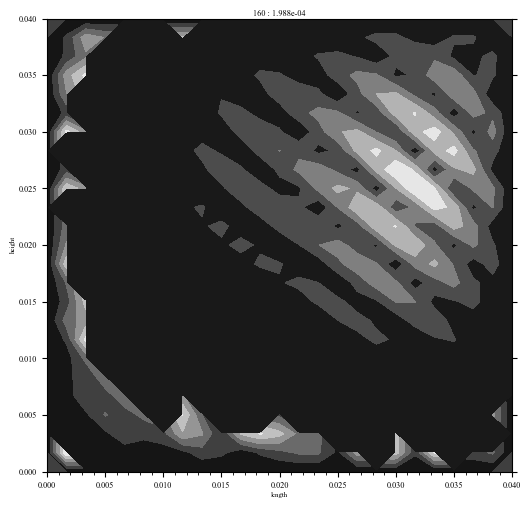

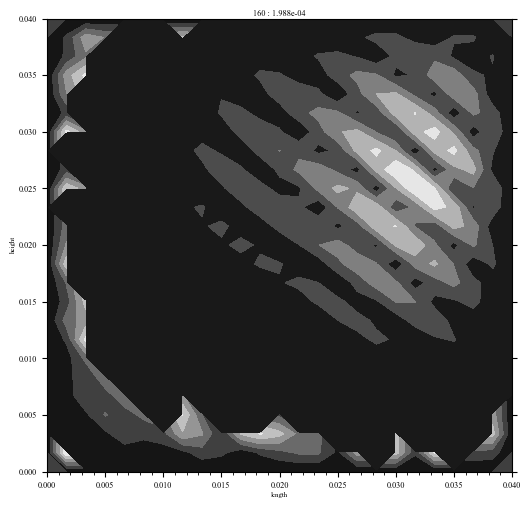

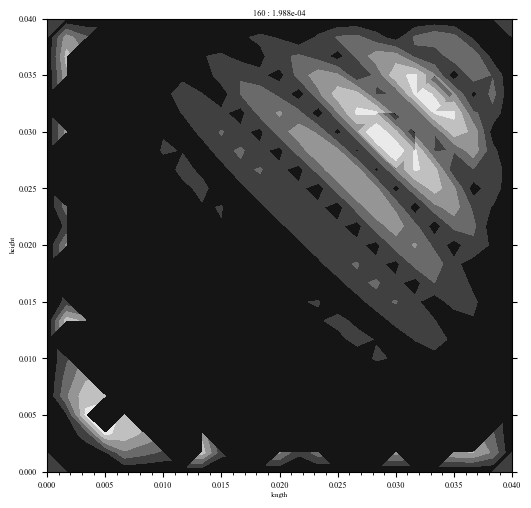

In [7]:
Results = loooop(0)
#Results = Parallel(n_jobs=62)(delayed(loooop)(i) for i in range(8))
#for i in range(8):
#    Results = loooop(i)
#    for j in range(20):
#        print(np.sum(Results[0][j*8][0]),np.sum(Results[1][j*8][0]),np.sum(Results[2][j*8][0]))

In [8]:
Summary = []
for i in range(8):
    for k in range(20):
        j=k*8
        Summary.append([np.sum(Results[i][0][j][0]), np.sum(Results[i][1][j][0]), np.sum(Results[i][2][j][0])])


IndexError: tuple index out of range

In [ ]:
str(int('{0:08b}'.format(2))).zfill(3)

In [ ]:
np.shape(Results)

In [ ]:
np.shape(Summary)

In [ ]:
Summary

In [ ]:
'''
    
        np.savetxt(str(i)+'V0.csv', Rail.VelocityCut(0), delimiter=",")
        np.savetxt(str(i)+'V1.csv', Rail.VelocityCut(1), delimiter=",")
        np.savetxt(str(i)+'V2.csv', Rail.VelocityCut(1), delimiter=",")
        np.savetxt(str(i)+'S0.csv', Rail.StressCut(0,1,1), delimiter=",")
        np.savetxt(str(i)+'S1.csv', Rail.StressCut(1,1,1), delimiter=",")
        np.savetxt(str(i)+'S2.csv', Rail.StressCut(2,1,1), delimiter=",")

    TempZ=Rail.StressCut(2,1,1)
    np.savetxt(str(i)+'S11.csv', TempZ, delimiter=",")
    TempZ=Rail.StressCut(2,1,0)
        np.savetxt(str(i)+'S10.csv', TempZ, delimiter=",")
        TempZ=Rail.StressCut(2,1,2)
        np.savetxt(str(i)+'S12.csv', TempZ, delimiter=",")
        TempZ=Rail.StressCut(2,0,0)
        np.savetxt(str(i)+'S00.csv', TempZ, delimiter=",")
        TempZ=Rail.StressCut(2,0,2)
        np.savetxt(str(i)+'S02.csv', TempZ, delimiter=",")
        TempZ=Rail.StressCut(2,2,2)
        np.savetxt(str(i)+'S22.csv', TempZ, delimiter=",")
    
    
    
    x,y,z, Rail.MaxX, Rail.MaxY, Rail.MaxZ
np.sqrt(Rail.Gv[2,1,:,:]**2+Rail.Gv[0,1,:,:]**2+Rail.Gv[1,1,:,:]**2)
'''

def ThreeDimmAnimate(FourDVector):
    # create volumes, loading them into opengl memory, and insert into container.
    f = vv.clf()
    a = vv.gca()
    m = vv.MotionDataContainer(a)

    for vol in FourDVector:
        t = vv.volshow(vol)
        t.parent = m
        t.colormap = vv.CM_HOT
        # Remove comments to use iso-surface rendering
        #t.renderStyle = 'iso'
        #t.isoThreshold = 0.2

    # set some settings
    a.daspect = 1,1,-1
    a.xLabel = 'x'
    a.yLabel = 'y'
    a.zLabel = 'z'

    # Enter main loop
    app = vv.use()
    app.Run()

In [ ]:
#ThreeDimmAnimate(AllVelocities)

In [ ]:
#ThreeDimmAnimate(VelocitiesX)

In [ ]:
#ThreeDimmAnimate(VelocitiesY)

In [ ]:
#ThreeDimmAnimate(VelocitiesZ)